# Jacobs the back-and-forth method

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
import sys
sys.path.append("../")
from c_transform import c_transform
from jacobs import push_forward1
from push_forward import lap_solve

### Wasserstein distance $\int \phi d\nu + \int \phi^c d\mu$

In [3]:
# Wasserstein distance \int \phi d\nu + \int \phi^c d\mu
def w2(phi, psi, mu, nu):
    return np.sum(phi * nu + psi * mu)

### every ascent step, update $\sigma$

各勾配ステップ後に、$J(\phi_{n+1})-J(\phi_n)$ を2乗ノルム$\| \nabla_{\dot{H}^1} J(\phi) \|_{\dot{H}^1}^2$ （$I$および$\psi, \psi$の場合についても同様）に比較.

$$
- \sigma_n \beta_2 \|\nabla_{\dot{H}^1} J(\phi_n)\|^2 \leq J(\phi_n)-J(\phi_{n+1}) \leq - \sigma_n \beta_1 \|\nabla_{\dot{H}^1} J(\phi_n)\|_{\dot{H}^1}^2.
$$

もし右の不等式が成立しない場合、
$\sigma_n$を減らすために$\sigma_{n+1}=\alpha_2\sigma_n$を取る。
左の不等式が成立しない場合、$\sigma_n$を増やすために$\sigma_{n+1}=\alpha_1\sigma_n$を取る。
全ての実験において、$\beta_1 = \frac{1}{4},\beta_2 = \frac{3}{4}, \alpha_1 = \frac{5}{4}, \alpha_2 = \frac{4}{5}$とし、$\sigma = 8 \min(\|\mu\|_{L^\infty}^{-1}, \|\nu\|_{L^\infty}^{-1})$を初期値として選択します。


In [4]:
def update_sigma(diff, H1_sq, sigma):
    if diff < 0.:
        sigma *= 0.1
    elif diff > H1_sq * sigma * upper:
        sigma *= scaleUp
    elif diff < H1_sq * sigma * lower:
        sigma *= scaleDown
    return sigma

### ascent step of $J(\phi) = \int \phi d\nu + \int \phi^c d\mu$

fills $\phi$ and $\phi_c$, returns new $\sigma$.

\begin{align}
  \phi_{n+\frac{1}{2}} &= \phi_n + \sigma \nabla_{\dot{H}^1} J(\phi_n),\\
  \psi_{n+\frac{1}{2}} &= (\phi_{n+\frac{1}{2}})^c,\\
  \psi_{n+1} &= \psi_{n+\frac{1}{2}} + \sigma \nabla_{\dot{H}^1} I(\psi_{n+\frac{1}{2}}), \\
  \quad \phi_{n+1} &= (\psi_{n+1})^c.
\end{align} 

### (1) $\,\phi_{n+\frac{1}{2}} = \phi_n + \sigma \nabla_{\dot{H}^1} J(\phi_n)$, 

   $\nabla_{\dot{H}^1} J(\phi_n) =  (- \Delta)^{-1} (\nu - T_{\phi\#}\mu), \qquad (\nu - T_{\phi\#}\mu) =: \rho$.

   $T_{\phi\#}\mu = x - (\nabla h)^{-1}(\nabla\phi^c(x))$
   
   コスト関数$c(x, y) = \frac{1}{2}|x - y|^2$のとき,

   $T_{\phi\#}\mu = x - (\nabla h)^{-1}(\nabla\phi^c(x)) =  x - \nabla\phi^c(x)$

   よって,

   $\phi_{n+\frac{1}{2}} = (- \Delta)^{-1} (\nu - (x - \nabla\phi^c(x)))$


In [5]:
"""
for k in range(300):
    phi_c, _ = c_transform(x, phi, p)                                 #1-1
    phi += sigma * lap_solve(nu - push_forward1(mu, phi_c, h))        #1-2      phi_{n + 1/2} = phi_n + sigma * 
    psi, _ = c_transform(x, phi, p)                                   #2        psi_{n + 1/2} = (phi_{n + 1/2})^c
    
    psi_c, _ = c_transform(x, psi, p)                                 #3-1
    psi += sigma * lap_solve(mu - push_forward1(nu, psi_c, h))        #3-2
    phi, _ = c_transform(x, psi, p)                                   #4        phi_{n + 1} = (psi_{n + 1})^c
    
    title = ax.text(4.5, 1.15, 'back-and-forth update $\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))
    img1, = ax.plot(x, push_forward1(nu, psi_c, h), color='red',label=r'$T_{\phi \#} \mu$')
    img2, = ax.plot(x, push_forward1(mu, phi_c, h), color='blue', label=r'$T_{\psi \#} \nu$')
    
    if k % 1 == 0:
        ax.legend(prop={'size': 15})
        artists.append([img1, img2, title])
    
ani = animation.ArtistAnimation(fig, artists, interval=2, repeat_delay=1000)
plt.show()

"""

"\nfor k in range(300):\n    phi_c, _ = c_transform(x, phi, p)                                 #1-1\n    phi += sigma * lap_solve(nu - push_forward1(mu, phi_c, h))        #1-2      phi_{n + 1/2} = phi_n + sigma * \n    psi, _ = c_transform(x, phi, p)                                   #2        psi_{n + 1/2} = (phi_{n + 1/2})^c\n    \n    psi_c, _ = c_transform(x, psi, p)                                 #3-1\n    psi += sigma * lap_solve(mu - push_forward1(nu, psi_c, h))        #3-2\n    phi, _ = c_transform(x, psi, p)                                   #4        phi_{n + 1} = (psi_{n + 1})^c\n    \n    title = ax.text(4.5, 1.15, 'back-and-forth update $\\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))\n    img1, = ax.plot(x, push_forward1(nu, psi_c, h), color='red',label=r'$T_{\\phi \\#} \\mu$')\n    img2, = ax.plot(x, push_forward1(mu, phi_c, h), color='blue', label=r'$T_{\\psi \\#} \nu$')\n    \n    if k % 1 == 0:\n        ax.legend(prop={'size': 15})\n        artists.append(

In [6]:
def ascent(phi, phi_c, mu, nu, sigma):
    phi_c, _ = c_transform(x, phi, x)                        # 1-1  phi_c, _ = c_transform(x, phi, p)

    old_J = w2(phi, phi_c, mu, nu)  

    pfwd = push_forward1(mu, phi_c, h)              # 1-2-1     pfwd : T_{\phi\#}\mu = x - (\nabla h)^{-1}(\nabla\phi^c(x)) = x - \nabla\phi^c(x)
    rho = nu - pfwd                                 # 1-2-2     rho = \nu - T_{\phi\#}\mu
    # TODO: This is by far the slowest part of the algorithm
    lp = lap_solve(rho)                             # 1-2-3     lp: \nabla_{\dot{H}^1} J(\phi_n) = (- \Delta)^{-1} * rho
    phi += sigma * lp                               # 1-2-4   phi_{n + 1/2} = phi_n + sigma * lp
####################################################################

    phi_c, _ = c_transform(x, phi, x)                    # 2    psi_{n + 1/2} = (phi_{n + 1/2})^c
    J = w2(phi, phi_c, mu, nu)
    H1_sq = np.mean(rho * lp)                        #######       ?
    return update_sigma(J - old_J, H1_sq, sigma), J, H1_sq, phi, phi_c, pfwd   #  ?


### Fix $\alpha_1, \alpha_2, \beta_1, \beta_2, \sigma_0$

In [7]:
scaleDown = 0.5  # \alpha_2
scaleUp   = 1 / scaleDown # \alpha_1
upper = 0.75     # \beta_2
lower = 0.25     # \beta_1

sigma = 200.
sigma1 = sigma
sigma2 = sigma
J = 0
H1_sq = 0
common_sigma = False

### Example. 1

<IPython.core.display.Javascript object>


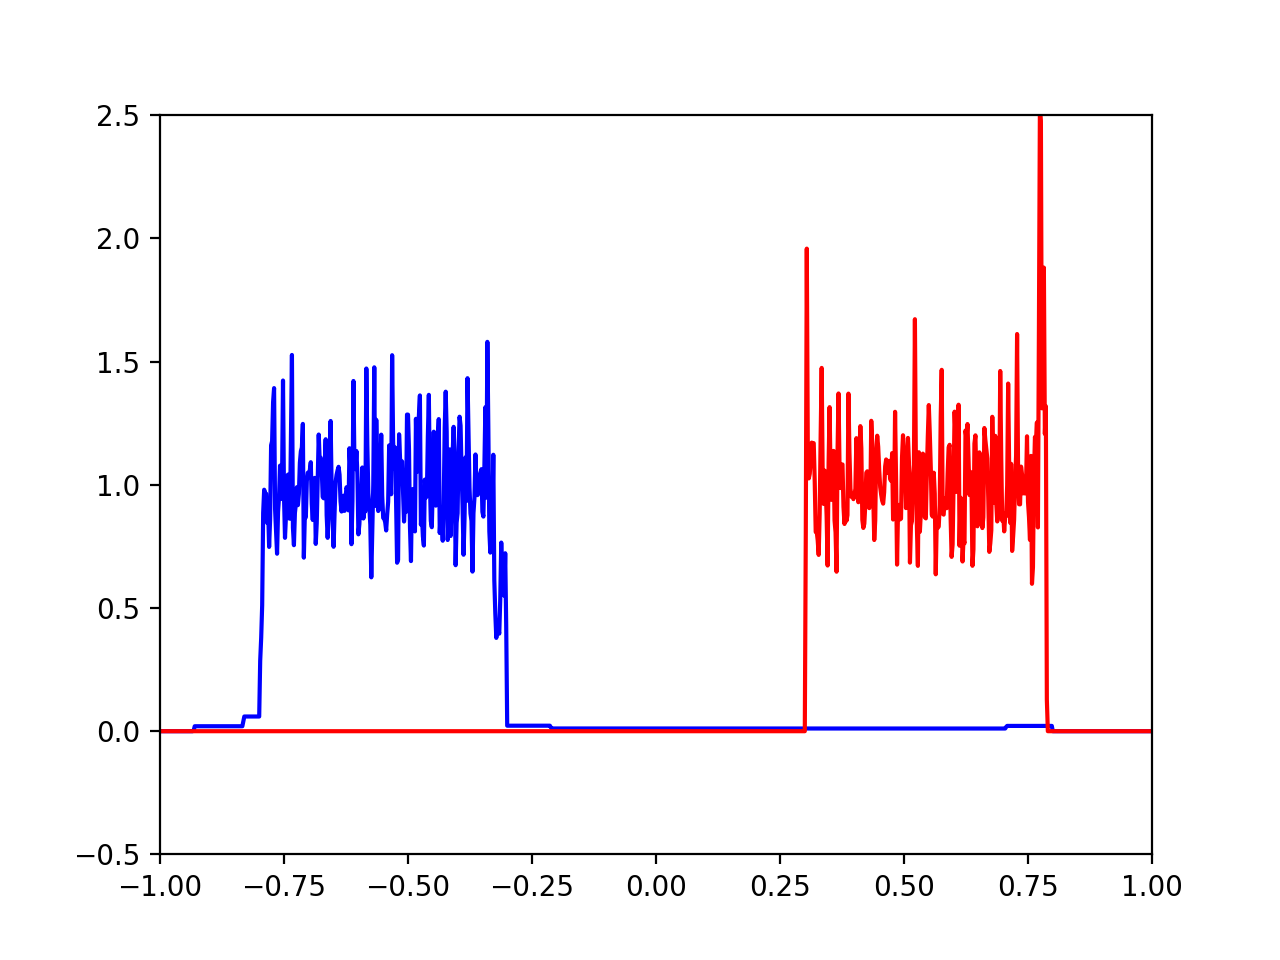

  0: J(φ) = 2.60159677242171e-263, (H¹)² = 0.0291, σ₂ = 3.5756e-264
  1: J(φ) = 143.323496352964, (H¹)² = 0.00361, σ₂ = 1.7878e-264
  2: J(φ) = 136.533457827715, (H¹)² = 0.00709, σ₂ = 8.9389e-265
  3: J(φ) = 148.66404477658, (H¹)² = 0.00103, σ₂ = 4.4694e-265
  4: J(φ) = 148.947683531477, (H¹)² = 0.000882, σ₂ = 2.2347e-265
  5: J(φ) = 140.171346408064, (H¹)² = 0.00528, σ₂ = 1.1174e-265
  6: J(φ) = 144.527378225354, (H¹)² = 0.0031, σ₂ = 5.5868e-266
  7: J(φ) = 149.540970301994, (H¹)² = 0.000587, σ₂ = 2.7934e-266
  8: J(φ) = 150.23044600701, (H¹)² = 0.000241, σ₂ = 1.3967e-266
  9: J(φ) = 149.489383766818, (H¹)² = 0.000609, σ₂ = 6.9835e-267
 10: J(φ) = 150.085582468544, (H¹)² = 0.000312, σ₂ = 3.4918e-267
 11: J(φ) = 150.521735177275, (H¹)² = 9.44e-05, σ₂ = 1.7459e-267
 12: J(φ) = 150.583110167879, (H¹)² = 6.35e-05, σ₂ = 8.7294e-268
 13: J(φ) = 150.590272758302, (H¹)² = 5.96e-05, σ₂ = 4.3647e-268
 14: J(φ) = 150.355055077182, (H¹)² = 0.000176, σ₂ = 2.1823e-268
 15: J(φ) = 150.56939126509, (

In [19]:
x = np.linspace(-1, 1, 1001)
p = x

mu = np.where((x > 0.3) & (x < 0.8), 1., 0.)     #True: 1. False: 0.
nu = np.copy(mu[::-1])

phi = np.zeros_like(x)
psi = np.zeros_like(x)  

h = x[1] - x[0]

fig, ax = plt.subplots()
artists = []

ax.set_xlim(-1,1)
ax.set_ylim(-0.5,2.5)

for k in range(100):
    #plt.title(r'back-and-forth update $\mu$ and $\nu$. Example 1:  Iterate ' + str(k+1))
    title = ax.text(4.5, 1.15, 'back-and-forth update $\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))
    
    sigma1, J, H1_sq, phi, psi, pfwd  = ascent(phi, psi, mu, nu, sigma1)

    print(f'{k:3}: J(φ) = {J}, (H¹)² = {H1_sq:.3}, σ₂ = {sigma1:.5}')
    if common_sigma:
        sigma2 = sigma1
    img2, = ax.plot(x, pfwd, color='blue')
    
    
    sigma2, J, H1_sq, psi, phi, pfwd = ascent(psi, phi, nu, mu, sigma2)
    if common_sigma:
        sigma1 = sigma2
        
    img1, = ax.plot(x, pfwd, color='red')
    
    
    if k % 1 == 0:  
        artists.append([img1] + [img2] + [title])
        
ani = animation.ArtistAnimation(fig, artists, interval=10, repeat_delay=1000)
plt.show()

### Example. 2

<IPython.core.display.Javascript object>


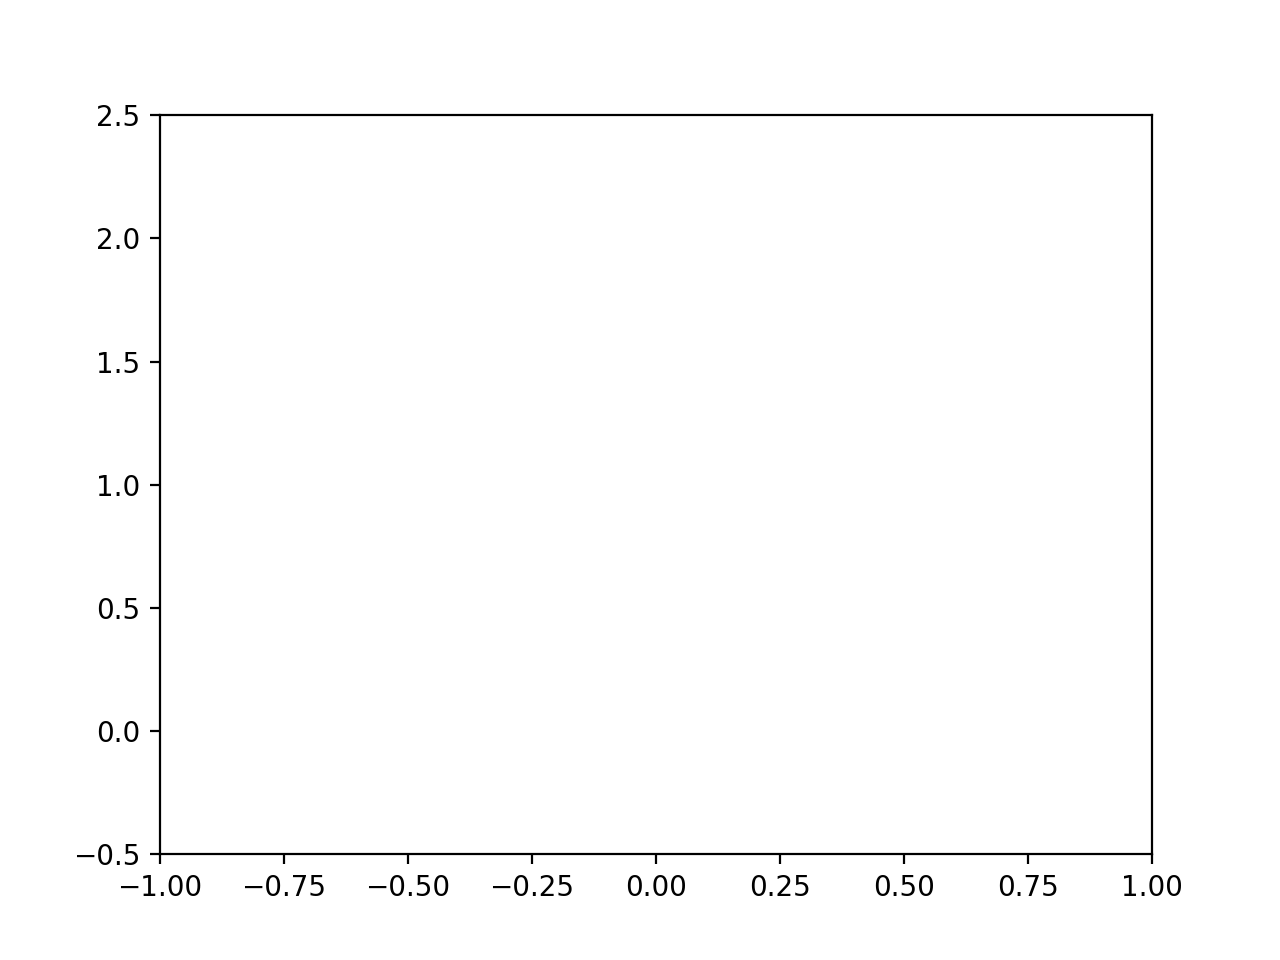

  0: J(φ) = 1.68791451704e-313, (H¹)² = 0.00386, σ₂ = 1.5291e-313
  1: J(φ) = 15.814966155227467, (H¹)² = 0.00333, σ₂ = 7.6453e-314
  2: J(φ) = 8.695882196930143, (H¹)² = 0.00527, σ₂ = 3.8226e-314
  3: J(φ) = 15.912581815178328, (H¹)² = 0.00431, σ₂ = 1.9113e-314
  4: J(φ) = 25.330145755615376, (H¹)² = 0.00195, σ₂ = 9.5566e-315
  5: J(φ) = 28.356495019121667, (H¹)² = 0.00119, σ₂ = 4.7783e-315
  6: J(φ) = 15.20840594476067, (H¹)² = 0.00448, σ₂ = 2.3892e-315
  7: J(φ) = 21.545845209102026, (H¹)² = 0.0029, σ₂ = 1.1946e-315
  8: J(φ) = 29.580625967651486, (H¹)² = 0.000885, σ₂ = 5.9729e-316
  9: J(φ) = 29.595883057912488, (H¹)² = 0.000883, σ₂ = 2.9864e-316
 10: J(φ) = 30.89301828753696, (H¹)² = 0.000559, σ₂ = 1.4932e-316
 11: J(φ) = 32.46803856516726, (H¹)² = 0.000164, σ₂ = 7.4661e-317
 12: J(φ) = 32.65340656695025, (H¹)² = 0.000116, σ₂ = 3.7331e-317
 13: J(φ) = 31.645240531197942, (H¹)² = 0.000369, σ₂ = 1.8665e-317
 14: J(φ) = 32.171474388360366, (H¹)² = 0.000238, σ₂ = 9.3326e-318
 15: J(φ)

In [21]:
x = np.linspace(-1, 1, 1001)
p = x

mu = np.where((x > 0.) & (x < 0.5), 0.5, 0.)     #True: 1. False: 0.
nu = np.where((x > -0.5) & (x < -0.25), 1., 0.)

phi = np.zeros_like(x)
psi = np.zeros_like(x)  

h = x[1] - x[0]

fig, ax = plt.subplots()
artists = []

ax.set_xlim(-1,1)
ax.set_ylim(-0.5,2.5)

for k in range(100):
    #plt.title(r'back-and-forth update $\mu$ and $\nu$. Example 1:  Iterate ' + str(k+1))
    title = ax.text(4.5, 1.15, 'back-and-forth update $\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))
    
    sigma1, J, H1_sq, phi, psi, pfwd  = ascent(phi, psi, mu, nu, sigma1)

    print(f'{k:3}: J(φ) = {J}, (H¹)² = {H1_sq:.3}, σ₂ = {sigma1:.5}')
    if common_sigma:
        sigma2 = sigma1
    img2, = ax.plot(x, pfwd, color='blue')
    
    
    sigma2, J, H1_sq, psi, phi, pfwd = ascent(psi, phi, nu, mu, sigma2)
    if common_sigma:
        sigma1 = sigma2
        
    img1, = ax.plot(x, pfwd, color='red')
    
    
    if k % 1 == 0:  
        artists.append([img1] + [img2] + [title])
        
ani = animation.ArtistAnimation(fig, artists, interval=10, repeat_delay=1000)
plt.show()

### Example. 3

<IPython.core.display.Javascript object>


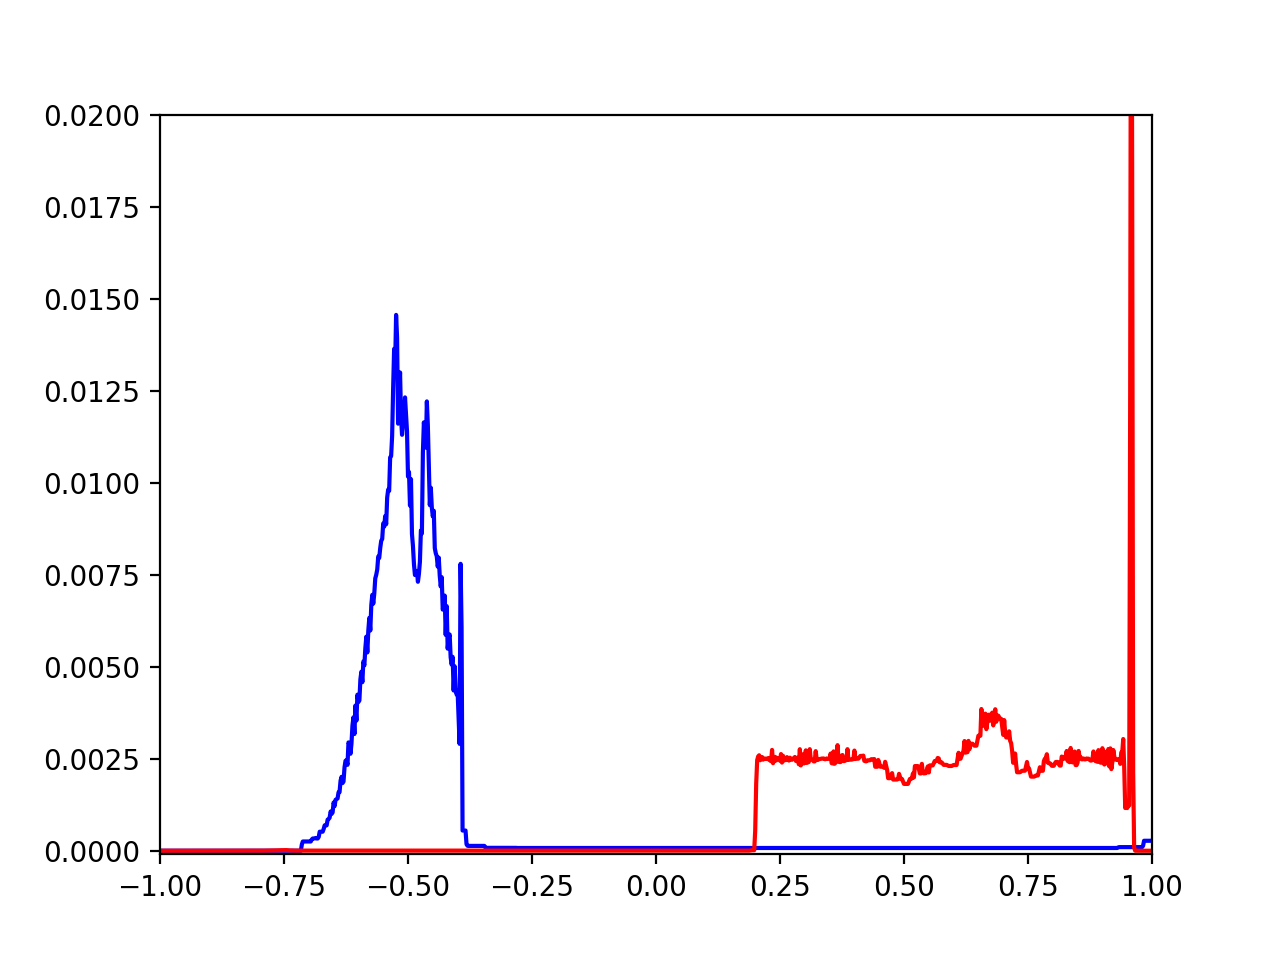

  0: J(φ) = 0.0, (H¹)² = 4.63e-07, σ₂ = 1.4582e-319
  1: J(φ) = 0.008203260531323664, (H¹)² = 4.6e-07, σ₂ = 1.4582e-319
  2: J(φ) = 0.024470562252506343, (H¹)² = 4.54e-07, σ₂ = 1.4582e-319
  3: J(φ) = 0.05640156764268919, (H¹)² = 4.42e-07, σ₂ = 1.4582e-319
  4: J(φ) = 0.11748206430462986, (H¹)² = 4.19e-07, σ₂ = 1.4582e-319
  5: J(φ) = 0.22628780030324513, (H¹)² = 3.72e-07, σ₂ = 1.4582e-319
  6: J(φ) = 0.38367357847365025, (H¹)² = 2.78e-07, σ₂ = 1.4582e-319
  7: J(φ) = 0.5099649629467329, (H¹)² = 1.37e-07, σ₂ = 1.4582e-319
  8: J(φ) = 0.5658945778462449, (H¹)² = 6.69e-08, σ₂ = 1.4582e-319
  9: J(φ) = 0.5812817909559436, (H¹)² = 4.74e-08, σ₂ = 1.4582e-319
 10: J(φ) = 0.6066436948577351, (H¹)² = 1.59e-08, σ₂ = 1.4582e-319
 11: J(φ) = 0.6080547715402594, (H¹)² = 1.43e-08, σ₂ = 1.4582e-319
 12: J(φ) = 0.5999990776514068, (H¹)² = 2.41e-08, σ₂ = 1.4582e-319
 13: J(φ) = 0.6060087663977467, (H¹)² = 1.66e-08, σ₂ = 1.4582e-319
 14: J(φ) = 0.6117063826850991, (H¹)² = 9.58e-09, σ₂ = 1.4582e-319
 15

In [22]:
x = np.linspace(-1, 1, 1001)
p = x

mu = np.where(x > 0.2, 1., 0.)     #True: 1. False: 0.
mu /= np.sum(mu)                   # mu = mu / np.sum(mu)
nu = np.exp(-(x + 0.5)**2 * 100)
nu /= np.sum(nu)  

phi = np.zeros_like(x)
psi = np.zeros_like(x)  

h = x[1] - x[0]

fig, ax = plt.subplots()
artists = []

ax.set_xlim(-1,1)
ax.set_ylim(-0.0001,0.02) 

for k in range(100):
    #plt.title(r'back-and-forth update $\mu$ and $\nu$. Example 1:  Iterate ' + str(k+1))
    title = ax.text(4.5, 1.15, 'back-and-forth update $\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))
    
    sigma1, J, H1_sq, phi, psi, pfwd  = ascent(phi, psi, mu, nu, sigma1)
    print(f'{k:3}: J(φ) = {J}, (H¹)² = {H1_sq:.3}, σ₂ = {sigma1:.5}')
    
    if common_sigma:
        sigma2 = sigma1
    img2, = ax.plot(x, pfwd, color='blue')
    
    
    sigma2, J, H1_sq, psi, phi, pfwd = ascent(psi, phi, nu, mu, sigma2)
    if common_sigma:
        sigma1 = sigma2
        
    img1, = ax.plot(x, pfwd, color='red')
    
    
    if k % 1 == 0:
        artists.append([img1] + [img2] + [title])
        
ani = animation.ArtistAnimation(fig, artists, interval=10, repeat_delay=1000)
plt.show()

### Example. 4

<IPython.core.display.Javascript object>


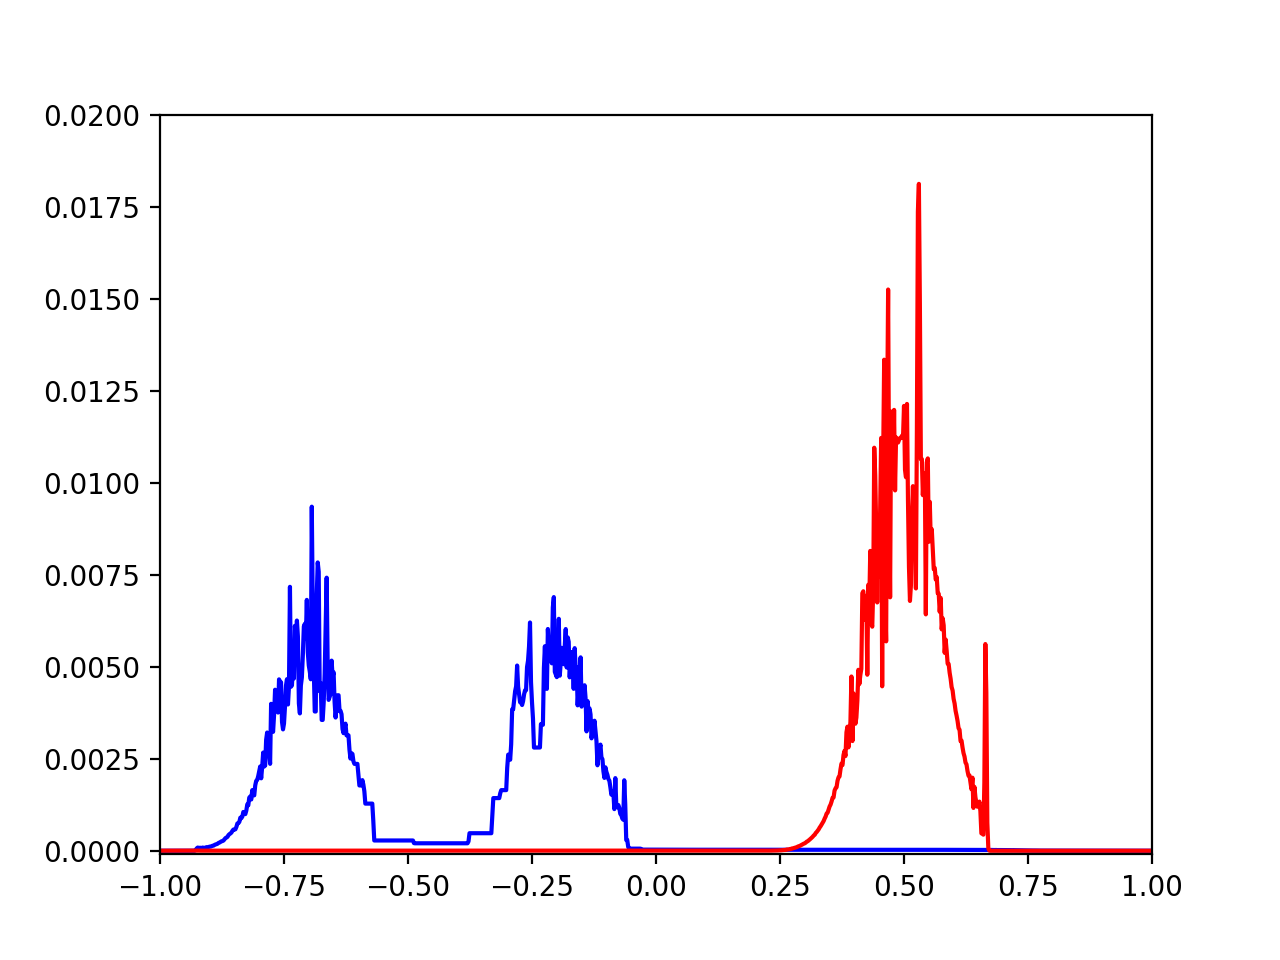

  0: J(φ) = 9.41528607871463e-298, (H¹)² = 3.82e-07, σ₂ = 1.1282e-293
  1: J(φ) = 0.0005939615809689392, (H¹)² = 3.82e-07, σ₂ = 5.6412e-294
  2: J(φ) = 0.001780718973182623, (H¹)² = 3.81e-07, σ₂ = 2.8206e-294
  3: J(φ) = 0.004150125515322282, (H¹)² = 3.8e-07, σ₂ = 1.4103e-294
  4: J(φ) = 0.008872530758392326, (H¹)² = 3.78e-07, σ₂ = 7.0515e-295
  5: J(φ) = 0.01825091109727692, (H¹)² = 3.74e-07, σ₂ = 3.5258e-295
  6: J(φ) = 0.036733222110420065, (H¹)² = 3.66e-07, σ₂ = 1.7629e-295
  7: J(φ) = 0.07253246499623173, (H¹)² = 3.5e-07, σ₂ = 8.8144e-296
  8: J(φ) = 0.13900394223405696, (H¹)² = 3.17e-07, σ₂ = 4.4072e-296
  9: J(φ) = 0.24926502840228912, (H¹)² = 2.51e-07, σ₂ = 2.2036e-296
 10: J(φ) = 0.3846761063466127, (H¹)² = 1.32e-07, σ₂ = 1.1018e-296
 11: J(φ) = 0.4626218956738223, (H¹)² = 2.71e-08, σ₂ = 5.509e-297
 12: J(φ) = 0.4650384813322905, (H¹)² = 1.71e-08, σ₂ = 2.7545e-297
 13: J(φ) = 0.4630741322271742, (H¹)² = 2.65e-08, σ₂ = 1.3773e-297
 14: J(φ) = 0.46561892947686045, (H¹)² = 1.76e-

In [20]:
x = np.linspace(-1, 1, 1001)
p = x

mu = np.exp(-(x - 0.5)**2 * 100)   #e^(-(x-0.5)^2 * 100)    #True: 1. False: 0.
mu /= np.sum(mu)                   # mu = mu / np.sum(mu)
nu = np.exp(-(x + 0.2)**2 * 100) + np.exp(-(x+0.7)**2 * 100)
nu /= np.sum(nu) 

phi = np.zeros_like(x)
psi = np.zeros_like(x)  

h = x[1] - x[0]

fig, ax = plt.subplots()
artists = []

ax.set_xlim(-1,1)
ax.set_ylim(-0.0001,0.02) 

for k in range(100):
    #plt.title(r'back-and-forth update $\mu$ and $\nu$. Example 1:  Iterate ' + str(k+1))
    title = ax.text(4.5, 1.15, 'back-and-forth update $\mu$ and $\nu$. Example 2:  Iterate {}'.format(str(k+1)))
    
    sigma1, J, H1_sq, phi, psi, pfwd  = ascent(phi, psi, mu, nu, sigma1)
    print(f'{k:3}: J(φ) = {J}, (H¹)² = {H1_sq:.3}, σ₂ = {sigma1:.5}')
    
    if common_sigma:
        sigma2 = sigma1
    img2, = ax.plot(x, pfwd, color='blue')
    
    
    sigma2, J, H1_sq, psi, phi, pfwd = ascent(psi, phi, nu, mu, sigma2)
    if common_sigma:
        sigma1 = sigma2
        
    img1, = ax.plot(x, pfwd, color='red')
    
    
    if k % 1 == 0:
        artists.append([img1] + [img2] + [title])
        
ani = animation.ArtistAnimation(fig, artists, interval=10, repeat_delay=1000)
plt.show()